### 🧠 결측치 처리 마인드맵

<img src="./결측치 처리_마인드맵.png" alt="결측치 마인드맵" width="600">

In [1]:
!pip install eli5==0.13.0

# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/Users/chung/Library/Fonts/NanumGothic.otf', 
    name='NanumGothic')                     
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가 (0,fe):가장 우선순위로 추가하겠다는 뜻
plt.rcParams.update({'font.size': 11, 'font.family': 'NanumGothic'}) # 폰트 설정
plt.rc('font', family='NanumGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

#import eli5
#from eli5.sklearn import PermutationImportance

In [2]:
pd.set_option('display.max_columns', None)   # 컬럼 모두 보이기
pd.set_option('display.max_colwidth', None)  # 컬럼명 길어도 다 보이기

train_path = '/Users/chung/JupyterNotebook/ML 경진대회/data/train.csv'
test_path  = '/Users/chung/JupyterNotebook/ML 경진대회/data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

dt['data_type'] = 'train'
dt_test['data_type'] = 'test'

concat = pd.concat([dt, dt_test]) 

concat = concat.rename(columns={'전용면적(㎡)':'전용면적'}) #이름 변경
concat.head(1)

concat.info()

print(concat[['좌표X', '좌표Y']].dtypes)


<class 'pandas.core.frame.DataFrame'>
Index: 1128094 entries, 0 to 9271
Data columns (total 53 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1125958 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1128094 non-null  object 
 11  해제사유발생일                 6195 non-null     float64
 12  등기신청일자                  1128094 non-null  object 
 13  거래유형                    1128094 non-null  object 
 14  중개사소재지    

In [3]:
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan) 

print("\n" + "="*80 + "\n") 

# Null값이 100만개 이상인 칼럼은 삭제 
print("\033[31m* 결측치가 100만개 이하인 변수들 :\033[0m", list(concat.columns[concat.isnull().sum() <= 1000000]))

print("\n\n")

# 남겨질 변수들은 아래와 같습니다.
print("\033[31m* 결측치가 100만개 이상인 변수들 :\033[0m", list(concat.columns[concat.isnull().sum() >= 1000000]))

print("\n" + "="*80 + "\n") 

# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 1000000])
concat_select = concat[selected]

concat_select.info()



* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'data_type']



* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자']


<class 'pandas.core.frame.DataFrame'>
Index: 1128094 entries, 0 to 9271
Data columns (total 45 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-

### 연속형 변수 vs. 범주형 변수 

In [4]:
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("📌 연속형 변수:", continuous_columns)

print("\n" + "="*80 + "\n") 

print("📌 범주형 변수:", categorical_columns)

📌 연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target']


📌 범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', 'data_type']


In [5]:
#범주형 변수 결측치 처리 

concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

### 연속형 변수의 상관계수 확인

단계 & 목적

1️⃣ 상관계수 행렬 계산: 연속형 변수들의 관계 파악
2️⃣ 높은 상관 변수쌍 저장: 관계가 강한 변수들 찾기
3️⃣ 양방향 중복 제거: (A,B) (B,A) 중복 제거
4️⃣ 중요한 변수 목록: 히트맵 대상 변수 추출
5️⃣ 작은 상관계수 행렬: 복잡도 낮춘 히트맵용
6️⃣ 히트맵 시각화: 인사이트 확보
7️⃣ 변수쌍 정리 출력: 사람이 직접 확인

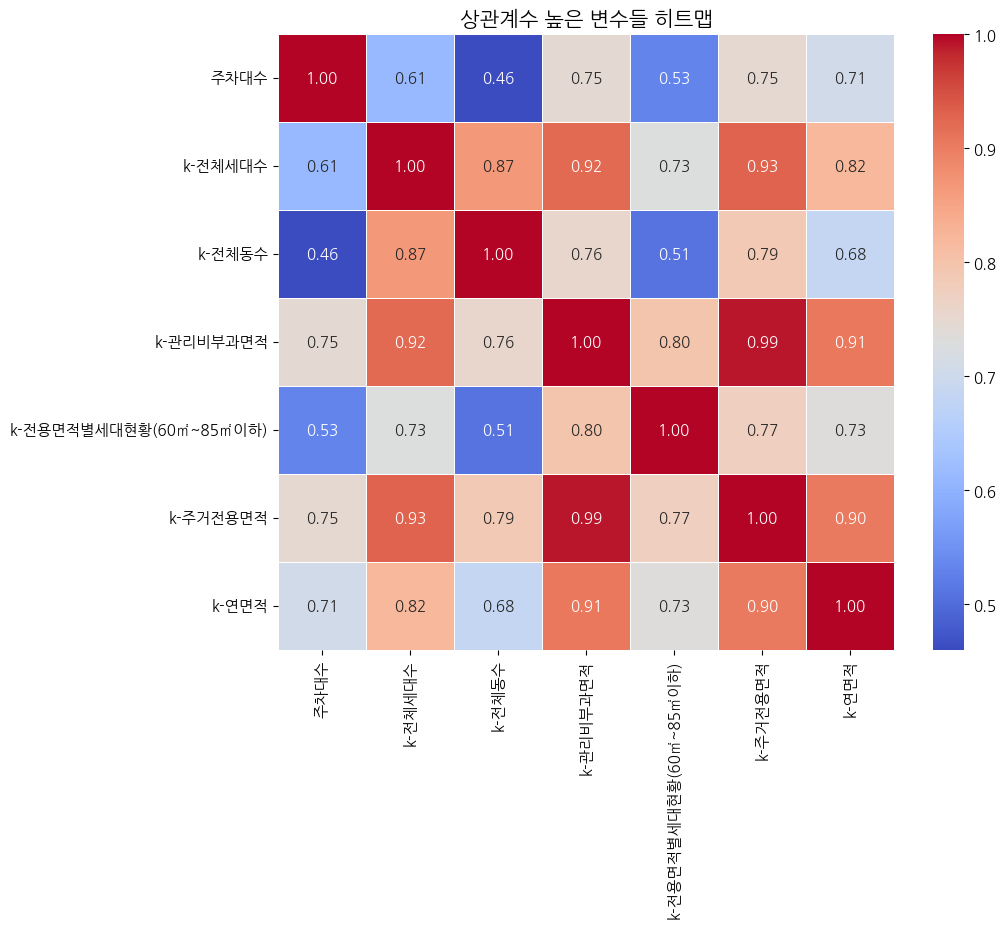


✅ 상관계수 높은 변수쌍 (정리):

k-전체동수 ↔ k-전체세대수 : 0.866
k-전체동수 ↔ k-주거전용면적 : 0.787
k-관리비부과면적 ↔ k-전체동수 : 0.755
k-연면적 ↔ k-전체세대수 : 0.819
k-전체세대수 ↔ k-주거전용면적 : 0.93
k-관리비부과면적 ↔ k-전체세대수 : 0.923
k-전용면적별세대현황(60㎡~85㎡이하) ↔ k-전체세대수 : 0.73
k-연면적 ↔ k-주거전용면적 : 0.904
k-관리비부과면적 ↔ k-연면적 : 0.906
k-연면적 ↔ k-전용면적별세대현황(60㎡~85㎡이하) : 0.734
k-연면적 ↔ 주차대수 : 0.705
k-관리비부과면적 ↔ k-주거전용면적 : 0.991
k-전용면적별세대현황(60㎡~85㎡이하) ↔ k-주거전용면적 : 0.774
k-주거전용면적 ↔ 주차대수 : 0.749
k-관리비부과면적 ↔ k-전용면적별세대현황(60㎡~85㎡이하) : 0.797
k-관리비부과면적 ↔ 주차대수 : 0.746


In [6]:
# 1. 상관계수 행렬 계산
corr_matrix = concat_select[continuous_columns].corr()

# 2. 상관계수 높은 변수쌍 저장용 리스트
high_corr_pairs = []
seen_pairs = set() #양방향 중복 제거를 위한 set추가 

# 3. 상관계수 높은 변수쌍 추출
threshold = 0.7

for col in continuous_columns:
    # 절대값 기준 0.7 초과 & 자기 자신 제외
    high_corr = corr_matrix[col][(corr_matrix[col].abs() > threshold) & (corr_matrix[col].abs() < 1)]
    for related_col in high_corr.index:
        # 변수명 알파벳 순으로 정렬해서 튜플화
        pair = tuple(sorted([col, related_col]))
        
        # 중복 쌍이면 건너뛰기
        if pair in seen_pairs:
            continue
        
        seen_pairs.add(pair)  # 새로운 쌍 기록
        high_corr_pairs.append((pair[0], pair[1], round(high_corr[related_col], 3)))

# 4. 중복 방지 변수 set 만들기
important_cols = set()
for col1, col2, _ in high_corr_pairs:
    important_cols.add(col1)
    important_cols.add(col2)
important_cols = list(important_cols)

# 5. 상관계수 행렬 (작은 히트맵용)
small_corr_matrix = concat_select[important_cols].corr()

# 6. 히트맵 그리기
plt.figure(figsize=(10,8))
sns.heatmap(small_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)
plt.title('상관계수 높은 변수들 히트맵', fontsize=15)
plt.show()

# 7. 보기 좋은 변수쌍 출력 (Optional)
print("\n✅ 상관계수 높은 변수쌍 (정리):\n")
for var1, var2, corr_value in high_corr_pairs:
    print(f"{var1} ↔ {var2} : {corr_value}")

In [7]:
# 1. high_corr_pairs에서 변수 추출 (중복 제거)
corr_vars = set()
for var1, var2, _ in high_corr_pairs:
    corr_vars.add(var1)
    corr_vars.add(var2)

# 2. 결측치 현황 DataFrame 생성
missing_corr = concat_select[list(corr_vars)].isnull().sum().to_frame(name='Missing_Count')
missing_corr['Total_Count'] = len(concat_select)
missing_corr['Missing_Rate(%)'] = (missing_corr['Missing_Count'] / missing_corr['Total_Count'] * 100).round(2)

# 3. 보기 좋게 출력
from IPython.display import display

display(missing_corr.sort_values(by='Missing_Count', ascending=False))


,Missing_Count,Total_Count,Missing_Rate(%)
k-전체동수,877207,1128094,77.76
주차대수,876277,1128094,77.68
k-전용면적별세대현황(60㎡~85㎡이하),876170,1128094,77.67
k-주거전용면적,876170,1128094,77.67
k-전체세대수,876125,1128094,77.66
k-관리비부과면적,876125,1128094,77.66
k-연면적,876125,1128094,77.66


k-전용면적별세대현황(60㎡~85㎡이하)는 뒤에서 k-전용면적별세대현황(60㎡이하),k-85㎡~135㎡이하와 함께 한번에 처리할 것. 실제로 세대수가 없었을 가능성이 더 높다고 생각. 상관계수와 상관 없이 결측치 0으로 처리

In [8]:
# 우선 제거 대상 변수
remove_cols = ['k-관리비부과면적', 'k-전체세대수', 'k-연면적']

# 제거 적용
reduced_data = concat_select.drop(columns=remove_cols)

print("✅ 제거된 변수:", remove_cols)
print("✅ 제거 후 컬럼 수:", reduced_data.shape[1])

✅ 제거된 변수: ['k-관리비부과면적', 'k-전체세대수', 'k-연면적']
✅ 제거 후 컬럼 수: 42


상관계수 0.9이상인 변수 중 우선 제거 대상 변수 제거해줌.

✅ **남은 변수쌍**

- `k-전체동수` ↔ `k-주거전용면적` : **0.787**
- `k-주거전용면적` ↔ `주차대수` : **0.749**

In [9]:
# 보간 대상 변수 목록
interpolate_cols = ['k-전체동수', 'k-주거전용면적', '주차대수']

# 선형 보간 적용 (각 컬럼별로 독립적으로)
for col in interpolate_cols:
    reduced_data[col] = reduced_data[col].interpolate(method='linear', limit_direction='both')

# 결측치 확인
missing_after = reduced_data[interpolate_cols].isnull().sum()
print("✅ 선형 보간 후 결측치:\n", missing_after)


✅ 선형 보간 후 결측치:
 k-전체동수      0
k-주거전용면적    0
주차대수        0
dtype: int64


### ~~낮은 상관계수 처리~~

In [10]:
# 변수별 최대 상관계수 찾기 
# 1. 절대값 상관계수 계산
abs_corr_matrix = corr_matrix.abs()

# 2. 변수별 '자기 자신' 제외한 최대 상관계수 찾기
max_corr_per_var = {}

for col in continuous_columns:
    max_corr = abs_corr_matrix[col].drop(col).max()  # 자기 자신 제외
    max_corr_per_var[col] = max_corr

In [11]:
# 임계값: 0.7 이하 → 상관계수 낮음 → 단독 보간
auto_solo_features = [var for var, corr in max_corr_per_var.items() if corr < 0.7]

print("✅ 단독 보간 후보 변수:", auto_solo_features)

✅ 단독 보간 후보 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전용면적별세대현황(60㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '좌표X', '좌표Y', 'target']


In [12]:
solo_vars = ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전용면적별세대현황(60㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '좌표X', '좌표Y', 'target']

# 결측치 개수 확인
missing_counts = concat_select[solo_vars].isnull().sum().sort_values(ascending=False)

print("✅ 단독 보간 후보 변수들의 결측치 개수:")
print(missing_counts)

✅ 단독 보간 후보 변수들의 결측치 개수:
건축면적                  876279
좌표X                   876232
좌표Y                   876232
k-전용면적별세대현황(60㎡이하)    876170
k-85㎡~135㎡이하          876170
target                  9272
전용면적                       0
계약년월                       0
계약일                        0
층                          0
건축년도                       0
dtype: int64


In [13]:
# 결측률까지 한번에 

missing_info = concat_select[solo_vars].isnull().sum().to_frame(name='Missing_Count')
missing_info['Total_Count'] = len(concat_select)
missing_info['Missing_Rate(%)'] = (missing_info['Missing_Count'] / missing_info['Total_Count'] * 100).round(2)

missing_info = missing_info.sort_values(by='Missing_Count', ascending=False)

display(missing_info)  # 표 형태로 출력

,Missing_Count,Total_Count,Missing_Rate(%)
건축면적,876279,1128094,77.68
좌표X,876232,1128094,77.67
좌표Y,876232,1128094,77.67
k-전용면적별세대현황(60㎡이하),876170,1128094,77.67
k-85㎡~135㎡이하,876170,1128094,77.67
target,9272,1128094,0.82
전용면적,0,1128094,0.00
계약년월,0,1128094,0.00
계약일,0,1128094,0.00
층,0,1128094,0.00


In [14]:
# 결측 → 0으로 처리할 변수 리스트
zero_fill_cols = [
    'k-전용면적별세대현황(60㎡이하)',
    'k-전용면적별세대현황(60㎡~85㎡이하)',
    'k-85㎡~135㎡이하'
]

# 결측치 → 0으로 채우기 (inplace 적용)
reduced_data[zero_fill_cols] = reduced_data[zero_fill_cols].fillna(0)

# 적용 결과 확인 (선택)
print(reduced_data[zero_fill_cols].isnull().sum())

k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
dtype: int64


In [15]:
#건축 면적 선형 보간 

reduced_data['건축면적'] = reduced_data['건축면적'].interpolate(method='linear')

print("✅ 건축면적 보간 후 결측치 개수:", reduced_data['건축면적'].isnull().sum())

✅ 건축면적 보간 후 결측치 개수: 0


In [16]:
# X,Y 좌표 
# 좌표 보유 데이터로 딕셔너리 만들기
x_map = reduced_data.dropna(subset=['좌표X']).set_index('번지')['좌표X'].to_dict()
y_map = reduced_data.dropna(subset=['좌표Y']).set_index('번지')['좌표Y'].to_dict()

# 결측치 채우기
reduced_data['좌표X'] = reduced_data['좌표X'].fillna(reduced_data['번지'].map(x_map))
reduced_data['좌표Y'] = reduced_data['좌표Y'].fillna(reduced_data['번지'].map(y_map))

# ✅ 결측치 개수 확인
missing_x = reduced_data['좌표X'].isnull().sum()
missing_y = reduced_data['좌표Y'].isnull().sum()

print(f"✅ '좌표X' 남은 결측치: {missing_x}")
print(f"✅ '좌표Y' 남은 결측치: {missing_y}")


✅ '좌표X' 남은 결측치: 658115
✅ '좌표Y' 남은 결측치: 658115


In [17]:
# 결측치 개수 및 비율 계산
missing_summary = reduced_data.isnull().sum().to_frame(name='Missing_Count')
missing_summary['Total_Count'] = len(reduced_data)
missing_summary['Missing_Rate(%)'] = (missing_summary['Missing_Count'] / missing_summary['Total_Count'] * 100).round(2)

# 결측치 많은 순으로 정렬해서 보기 좋게 출력
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0]  # 결측치 있는 컬럼만
missing_summary = missing_summary.sort_values(by='Missing_Count', ascending=False)

from IPython.display import display
display(missing_summary)

,Missing_Count,Total_Count,Missing_Rate(%)
좌표X,658115,1128094,58.34
좌표Y,658115,1128094,58.34
target,9272,1128094,0.82
